In [10]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from scipy.sparse import csc_matrix, coo_matrix
import pandas as pd
from scipy import sparse
sys.path.append("..")
from spykesim import editsim
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
%matplotlib inline

In [2]:
def genpoisson_spiketrain(rate, duration, dt = 0.001):
    offset = duration
    events = np.cumsum(np.random.exponential(scale = 1 / rate, size = int(duration*rate + offset)))
    return np.round(events[np.logical_and(0 < events, events < duration)], -int(np.log10(dt)))

def genpoisson_spiketrains(nneurons, rate, dt, duration):
    spike_timings = np.array([], dtype = np.float)
    spike_neurons = np.array([], dtype = np.int)
    for n in range(nneurons):
        spike_train = genpoisson_spiketrain(rate, dt, duration)
        spike_timings = np.r_[spike_timings, spike_train]
        spike_neurons = np.r_[spike_neurons, n * np.ones_like(spike_train, dtype = np.int)]
    return pd.DataFrame({
        "neuronid": spike_neurons,
        "spiketime": spike_timings
    })
def gen_sequence(nneurons = 10, seqlen = 0.1, dt = 0.001):
    return np.round(np.linspace(dt, seqlen-dt, nneurons), int(-np.log10(dt)))


In [3]:
def gen_sequence_mat(nneurons = 30, neurons = np.arange(10), seqlen_ms = 100, shrink = 1):
    spikes = np.linspace(0, (seqlen_ms - 1) / abs(shrink), len(neurons), dtype = np.int)
    if shrink < 0:
        spikes[::-1] = spikes
    mat = np.zeros((nneurons, seqlen_ms))
    for neuron, spike in zip(neurons, spikes):
        mat[neuron, spike] = 1
    return mat
def addnoise(mat):
    for row in range(mat.shape[0]):
        if mat[row, :].sum() >= 1:
            pass
#             mat[row, np.random.randint(0, mat.shape[1])] = 1
        else:
#             mat[row, np.random.randint(0, mat.shape[1])] = 1
            mat[row, np.random.randint(0, mat.shape[1])] = 1
    return mat

In [4]:
nseq = 100
shrinkages = [1, 5, -5]
nneurons = 30
nseq_kinds = 3
seqlen = 0.1
seqlen_ms = 100
mats = []
true_labels = []
nneurons_per_seq = nneurons // nseq_kinds
for idx in range(nseq_kinds):
    neurons = np.arange(idx*nneurons_per_seq, (idx+1)*nneurons_per_seq)
    for shrinkage in shrinkages:
        for _ in range(nseq):
            mats.append(addnoise(gen_sequence_mat(nneurons, neurons, seqlen_ms, shrink = shrinkage)))
            true_labels.append(idx)
true_labels = np.array(true_labels)            
binarray = []
spike_matrix = []
for idx, mat in enumerate(mats):
    if idx == 0:
        binarray = mat.copy()
        spike_matrix = np.sum(mat.copy(), axis=1)
    else:
        binarray = np.c_[binarray, mat]
        spike_matrix = np.c_[spike_matrix, np.sum(mat, axis=1)]
Z = np.zeros_like(spike_matrix)        
mean_spike_matrix = np.mean(spike_matrix, axis = 1)
std_spike_matrix = np.std(spike_matrix, axis = 1)
for row in range(spike_matrix.shape[0]):
    Z[row, :] = spike_matrix[row, :] - mean_spike_matrix[row]
    if std_spike_matrix[row] != 0:
        Z[row, :] /= std_spike_matrix[row]

C = np.dot(Z, Z.T) / Z.shape[1]

In [14]:
binarray_coo = coo_matrix(binarray)
binarray_csc = binarray_coo.tocsc()

a = 0.01
window = seqlen_ms
simmat, times = editsim.eval_simmat(binarray_csc, window, window, a = a, lsh=False, njobs=os.cpu_count())

[2018-08-31 14:28:15,531] [MainThread] Execution of a function _eval_simvec starts
[2018-08-31 14:28:49,261] [MainThread] submit end
[2018-08-31 14:28:49,267] [MainThread] Progress of the calculation

  0%|          | 0.00/897 [00:00<?, ?it/s]
  0%|          | 1.00/897 [00:32<8:02:24, 32.3s/it]
  1%|          | 11.0/897 [00:32<43:30, 2.95s/it]  
  3%|▎         | 23.0/897 [00:32<20:35, 1.41s/it]
  3%|▎         | 23.0/897 [00:42<26:56, 1.85s/it]
  3%|▎         | 25.0/897 [00:56<33:02, 2.27s/it]
  4%|▍         | 36.0/897 [00:56<22:42, 1.58s/it]
  4%|▍         | 36.0/897 [01:12<28:55, 2.02s/it]
  5%|▌         | 49.0/897 [01:13<21:17, 1.51s/it]
  7%|▋         | 66.0/897 [01:13<15:30, 1.12s/it]
  8%|▊         | 73.0/897 [01:29<16:55, 1.23s/it]
 10%|▉         | 89.0/897 [01:30<13:37, 1.01s/it]
 10%|▉         | 89.0/897 [01:42<15:31, 1.15s/it]
 11%|█         | 97.0/897 [01:46<14:35, 1.09s/it]
100%|██████████| 897/897 [10:29<00:00, 1.42it/s][2018-08-31 14:39:19,021] [MainThread] Progress of the

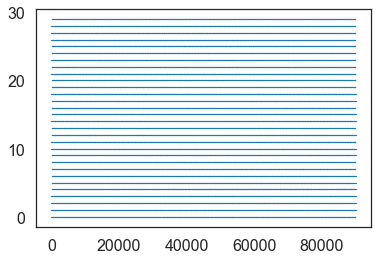

In [15]:
plt.scatter(binarray_coo.col, binarray_coo.row, s = 0.5)

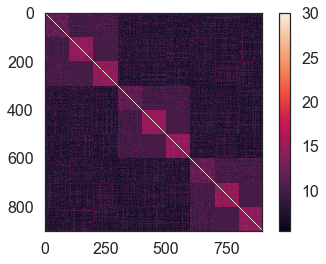

In [16]:
plt.imshow(simmat)
plt.colorbar()

In [17]:
th_ = np.percentile(simmat, 50)
X = []
Y = []
for idx1, mat1 in enumerate(mats[:-2]):
    for idx2, mat2 in enumerate(mats[:-2]):
        X.append([mat1, mat2])
        Y.append(1 if simmat[idx1, idx2] >= th_ else 0)
X = np.array(X)
Y = np.array(Y)

In [18]:
one_indices = np.where(np.array(Y) == 1)[0]
mask = np.zeros(Y.shape, dtype = bool)
mask[one_indices] = True
Y_one = Y[mask]
Y_none = Y[~mask]
X_one = X[mask]
X_none = X[~mask]

In [19]:
true_labels.shape

(900,)

In [20]:
ndata = 100
X_ = np.r_[X_one[:ndata], X_none[:ndata]]
Y_ = np.r_[Y_one[:ndata], Y_none[:ndata]]

In [21]:
from sklearn.model_selection import train_test_split
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(X_, Y_, test_size = 0.2)

In [22]:
xt_mean = np.mean(X_train_)
xt_std = np.std(X_train_)
yt_mean = np.mean(Y_train_)
yt_std = np.std(Y_train_)

X_train = (X_train_ - xt_mean) / xt_std
X_test = (X_test_ - xt_mean) / xt_std
Y_train = Y_train_
Y_test = Y_test_
# Y_train = (Y_train_ - yt_mean) / yt_std
# Y_test = (Y_test_ - yt_mean) / yt_std

In [25]:
import tensorflow as tf
model = __import__('siamse')

/Users/kei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/kei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [26]:
tf.reset_default_graph()
snn = model.SNN(30, 10, 3, window)
history = snn.fit(X_train, Y_train,
                  X_test, Y_test,
                  epochs = 100, batch_size = 10, p_keep = .8, every=50)

epoch: 0, loss: 0.19314907491207123
test epoch: 0, loss: 0.19235014915466309
epoch: 50, loss: 0.0177629254758358
test epoch: 50, loss: 0.021549876779317856


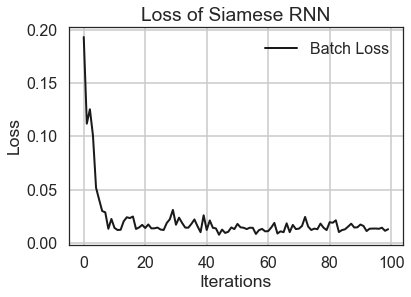

In [27]:
plt.plot(history["loss"], 'k-', lw=2, label='Batch Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss of Siamese RNN')
plt.grid()
plt.legend(loc='upper right')
plt.savefig("loss.pdf")

In [28]:
# Data Test

In [29]:
tmats = []
true_labels = []
nseq = 100
for idx in range(nseq_kinds):
    neurons = np.arange(idx*nneurons_per_seq, (idx+1)*nneurons_per_seq)
    for shrinkage in shrinkages:
        for _ in range(nseq):
            tmats.append(addnoise(gen_sequence_mat(nneurons, neurons, seqlen_ms, shrink = shrinkage)))
            true_labels.append(idx)
true_labels = np.array(true_labels)
spike_matrix = []
for idx, mat in enumerate(tmats):
    if idx == 0:
        spike_matrix = np.sum(mat.copy(), axis=1)
    else:
        spike_matrix = np.c_[spike_matrix, np.sum(mat, axis=1)]
Z = np.zeros_like(spike_matrix)        
mean_spike_matrix = np.mean(spike_matrix, axis = 1)
std_spike_matrix = np.std(spike_matrix, axis = 1)
for row in range(spike_matrix.shape[0]):
    Z[row, :] = spike_matrix[row, :] - mean_spike_matrix[row]
    if std_spike_matrix[row] != 0:
        Z[row, :] /= std_spike_matrix[row]
C = np.dot(Z.T, Z) / Z.shape[1]            

In [30]:
embedding = snn.embed(tmats)

In [31]:
from sklearn.decomposition import PCA, FastICA
pca = PCA(n_components=nseq_kinds, whiten=False)
pca_estimation = pca.fit_transform(C)

/Users/kei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/sklearn/decomposition/pca.py:505: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


In [32]:
ndata = true_labels.shape[0]

In [33]:
train_indices = np.random.choice(np.arange(ndata), size=int(ndata * 0.8), replace=False)
mask = np.zeros(ndata, dtype = bool)
mask[train_indices] = True
label_train = true_labels[mask]
label_test = true_labels[~mask]
embedding_train = embedding[mask]
embedding_test = embedding[~mask]
pca_train = pca_estimation[mask]
pca_test = pca_estimation[~mask]

In [34]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score, accuracy_score

/Users/kei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [35]:
fold = KFold(ndata, n_folds=5, shuffle=True, random_state=777)
searchCV = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,random_state=777
        ,max_iter=10000
        ,fit_intercept=True
        ,solver='newton-cg'
        ,multi_class="ovr"
        ,tol=10
    )
emb_cv = searchCV.fit(embedding_train, label_train)

In [43]:
emb_cv.scores_

{0: array([[0.51656509, 0.51664323, 0.51664323, 0.51664323, 0.51664323,
         0.51664323, 0.51664323, 0.51664323, 0.51844038, 0.51734646,
         0.51898734, 0.51898734, 0.51898734, 0.51898734, 0.51898734,
         0.51898734, 0.51898734, 0.51898734, 0.51898734, 0.51898734],
        [0.76790628, 0.76759179, 0.76759179, 0.76759179, 0.76759179,
         0.76759179, 0.76759179, 0.76759179, 0.76759179, 0.76735592,
         0.76735592, 0.76735592, 0.76735592, 0.76735592, 0.76735592,
         0.76735592, 0.76735592, 0.76735592, 0.76735592, 0.76735592],
        [0.7193038 , 0.72009494, 0.72009494, 0.72009494, 0.72009494,
         0.72009494, 0.72009494, 0.72009494, 0.71993671, 0.71946203,
         0.71946203, 0.71946203, 0.71946203, 0.71946203, 0.71946203,
         0.71946203, 0.71946203, 0.71946203, 0.71946203, 0.71946203]]),
 1: array([[0.44711758, 0.44719384, 0.44719384, 0.44719384, 0.44719384,
         0.44719384, 0.44719384, 0.44719384, 0.44719384, 0.44727009,
         0.4474226 , 0.

In [46]:
emb_cv.score(embedding_train, label_train)

0.5291666666666667

In [44]:
emb_cv.C_

array([1.e-02, 1.e-10, 1.e+00])

In [36]:
emb_score = emb_cv.scores_[1].max()

In [37]:
emb_score

0.7503495417119777

In [38]:
fold = KFold(ndata, n_folds=5, shuffle=True, random_state=777)
searchCV = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,random_state=777
        ,max_iter=10000
        ,fit_intercept=True
        ,solver='newton-cg'
        ,multi_class="ovr"
        ,tol=10
    )
pca_cv = searchCV.fit(pca_train, label_train)

In [39]:
pca_score = pca_cv.scores_[1].max()

In [40]:
pca_cv.scores_

{0: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
         0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
         0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
         0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]]),
 1: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
         0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
         0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
         0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]]),
 2: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
         0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
         0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0

In [288]:
pca_score

0.5

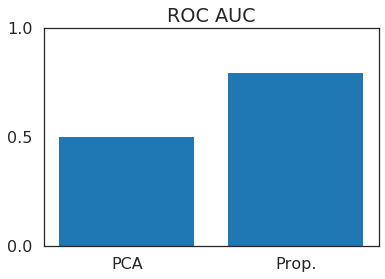

In [289]:
fig, ax = plt.subplots(1, 1)
ax.bar([1, 2], [pca_score, emb_score])
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.5, 1])
ax.set_xticks([1, 2])
ax.set_xticklabels(["PCA", "Prop."])
ax.set_title("ROC AUC")
fig.savefig("performance.pdf")

In [52]:
logreg = linear_model.LogisticRegression(C=1e+02)
logreg.fit(embedding_train, label_train)
embedding_predictions = logreg.predict(embedding_test)

In [53]:
embedding_predictions

array([1, 0, 1, 2, 0, 1, 1, 2, 2, 2, 2, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 0, 2,
       0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 2, 1, 0, 2, 1, 0, 2, 1, 2, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 2, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 2, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 2, 1, 2, 1, 2, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 2, 1, 2, 2, 2, 2, 2, 0,
       2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0,
       2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0])

In [54]:
accuracy_score(label_test, embedding_predictions)

0.48888888888888887

In [33]:
logreg = linear_model.LogisticRegression(C=1e+05)
logreg.fit(pca_train, label_train)
pca_predictions = logreg.predict(pca_test)

In [34]:
pca_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2])

In [45]:
accuracy_score(label_test, pca_predictions)

0.27777777777777779